In [1]:
!pip install CBFV

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 539.2/539.2 kB 9.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [3]:
df = pd.read_excel('/content/new_ds_typ.xlsx')

In [4]:
import CBFV
from CBFV import composition

In [5]:
data = df[["formula", "Temperature", "target"]]

In [6]:
x1 ,y1, feature, skipped = composition.generate_features(data, elem_prop='magpie', drop_duplicates= False, extend_features= True )

Processing Input Data: 100%|██████████| 340/340 [00:00<00:00, 18747.22it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 340/340 [00:00<00:00, 10194.40it/s]

	Creating Pandas Objects...


# Train - Test Split (80-20)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(x1, y1, test_size= 0.2, random_state=42 )

In [8]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import  GridSearchCV

In [9]:
#Define the model
gbr = GradientBoostingRegressor(random_state=42);

In [10]:
# Instantiate the standard scaler
scaler = StandardScaler()
# zero mean and unit variance
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [11]:
# Set the hyperparameters grid to search
param_grid ={
    'learning_rate' : [0.1, 0.2, 0.5],
    'n_estimators' : [50,100,200],
    'min_samples_split' : [2,5,10],
    'max_depth' : [10,20,30],
}

In [12]:
grid_search = GridSearchCV(gbr,param_grid=param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=-1)

In [13]:
grid_search.fit(X_train_scaled, Y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.5],
                         'max_depth': [10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [14]:
best_model = grid_search.best_estimator_
best_hyperparameteres = grid_search.best_params_

#print the details of best model
print(f"Best Model: {best_model}")
print(f"Best Hyperparameters : {best_hyperparameteres}")

Best Model: GradientBoostingRegressor(max_depth=10, min_samples_split=10, n_estimators=50,
                          random_state=42)
Best Hyperparameters : {'learning_rate': 0.1, 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}


In [15]:
# Predict the output
y_pred = best_model.predict(X_test_scaled)

In [16]:
#Evaluate the model
rmse = root_mean_squared_error(Y_test, y_pred)
r2 = r2_score(Y_test,y_pred)

print(f"Root Mean Square Error without scaling: {rmse}")
print(f"R2 for without scaling: {r2}")

Root Mean Square Error without scaling: 29.94907512022208
R2 for without scaling: 0.8246964026374929


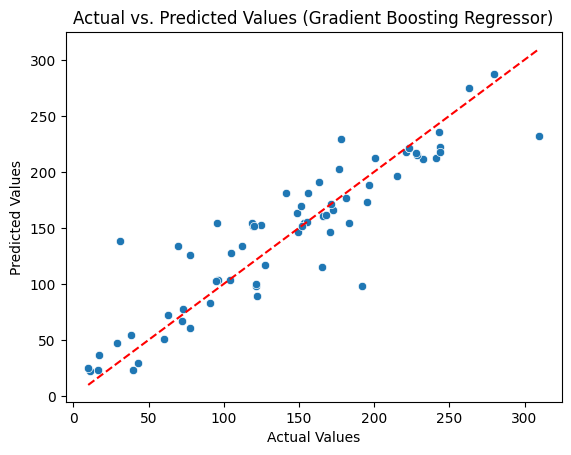

In [17]:
# Visualize the results
sns.scatterplot(x=Y_test, y=y_pred)
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--')  # 45-degree line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values (Gradient Boosting Regressor)")
plt.show()


In [18]:
Y_pred_train = best_model.predict(X_train_scaled)

In [19]:
# Evaluate the model
rmse_train = root_mean_squared_error(Y_train, Y_pred_train)
r2_train = r2_score(Y_train,Y_pred_train)

print(f"Mean Square Error without scaling: {rmse_train}")
print(f"R2 for without scaling: {r2_train}")

Mean Square Error without scaling: 10.37184207066736
R2 for without scaling: 0.9784941908440679


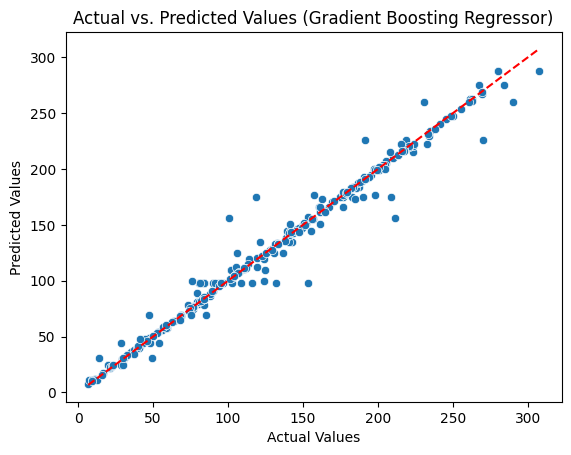

In [20]:
sns.scatterplot(x=Y_train, y=Y_pred_train)
plt.plot([min(Y_train), max(Y_train)], [min(Y_train), max(Y_train)], color='red', linestyle='--')  # 45-degree line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values (Gradient Boosting Regressor)")
plt.show()


# Bayesian Optimization

In [21]:
from scipy.stats import norm

In [22]:
# DETERMINING the mean and standard Deviation using bootstrap sampling with 100 bootstrap samples

def bootstrap_estimator(model, X_train, y_train, X_test, n_iter=100):
    """
    Function to estimate the mean and standard deviation

    paramenters:
    model = best model hyperparameters
    X_train = training features
    y_tain = training target
    X_test = test features
    n_iter = no of bootstrap sample
    seed = 20 is fixed to have repeatability in boot straping

    return:
    returns mean and standard deviation
    """

    bootstrap_preds = np.zeros([len(X_test), n_iter])

    index = np.arange(X_train.shape[0])

    ## set the seed to repeat the boot strapping
    np.random.seed(20)
    for i in range(n_iter):
        #sample from X_train, y_train
        index_sampled = np.random.choice(index, size=X_train.shape[0], replace=True)

        X_train_sample = pd.DataFrame(X_train).iloc[index_sampled.tolist(),:]
        # Access y_train using .iloc to ensure positional indexing
        y_train_sample = y_train.iloc[index_sampled]

        #model.fit(X_train_sample, y_train_sample)
        model.fit(X_train_sample, y_train_sample)

        #pred_i = model.predict(X_test)

        pred_i = model.predict(X_test)
        #print('pred_i:', pred_i)

        bootstrap_preds[:,i] = pred_i
        #print(bootstrap_preds)

    return(bootstrap_preds.mean(1),bootstrap_preds.std(1))

## Expection Improvement Calculation


def Expected_Improvement(X_test, X_train_all, y_train_all, model, xi=0.01):

    '''
     Calcualting the Expected Improvement
     More information : http://krasserm.github.io/2018/03/21/bayesian-optimization/
     parameters: mean, std, y_train, xi
     return :
     Expected improvement value

    '''

    mu_x, sigma_x = bootstrap_estimator(model, X_train_all, y_train_all, X_test, n_iter=100)
    mu_max = np.max(y_train_all)
    # mu_max is the highest material property value in the training data which is at 24 deg C
    # therefore the candidate search space is choosen at 24 deg C

    diff = (mu_x-mu_max-xi)
    z = diff/sigma_x
    ei = diff*norm.cdf(z)+sigma_x*norm.pdf(z)
    ei[sigma_x == 0.0] = 0.
    return(ei,mu_x,sigma_x)

In [23]:
mean , std  = bootstrap_estimator(best_model, X_train, Y_train, X_test, n_iter=100)

print(pd.DataFrame([mean,std]))

mean_train , std_train  = bootstrap_estimator(best_model, X_train, Y_train, X_train, n_iter=100)


          0           1           2           3           4          5   \
0  51.487401  121.583258  138.309013  119.473400  166.159683  99.099810   
1   5.006860   29.248002   24.574030   16.221175    3.744868   4.970154   

           6           7          8           9   ...          58         59  \
0  262.235038  215.049021  49.349897  228.719676  ...  166.545372  29.389631   
1   27.567847    6.055222  18.779974   24.463914  ...   11.731404  15.529905   

           60         61          62          63         64          65  \
0  129.495186  89.937995  218.627042  177.722262  96.598675  186.765992   
1   48.844578  33.101506    7.655590   15.999240   9.854699   49.847257   

           66         67  
0  102.287847  25.720102  
1    9.480484   9.473594  

[2 rows x 68 columns]


### Plotting the uncertainties for the test data

r2 score test data: 0.814788927936591
r2 score train data: 0.9643785221137892


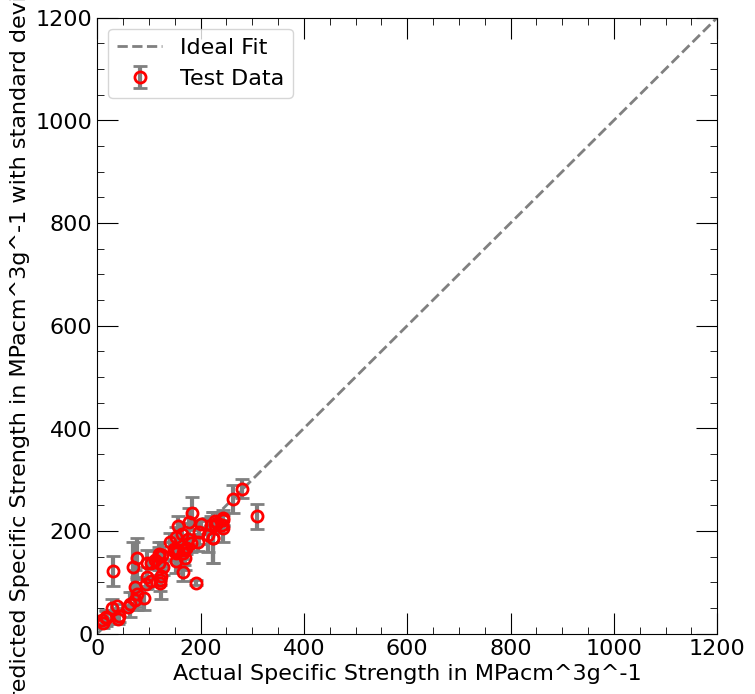

In [24]:
plt.figure(figsize=(8,8))

plt.errorbar(Y_test,mean,yerr=std,ecolor = 'grey',mfc='None', mec='red',mew=2,elinewidth= 3,ls = 'none',marker='o',markersize=8,solid_capstyle='projecting', capsize=5,label='Test Data')

plt.xlabel('Actual Specific Strength in MPacm^3g^-1',fontsize=16)
plt.ylabel('Predicted Specific Strength in MPacm^3g^-1 with standard deviation',fontsize=16)
plt.axline((0, 0), (1200, 1200), linewidth=2, color='grey',linestyle='dashed',label='Ideal Fit')
plt.legend(fontsize=16)
plt.xlim(0,1200)
plt.ylim(0,1200)

plt.minorticks_on()
plt.tick_params(labelsize=16)
plt.tick_params(direction='in',which='major', length=15, bottom=True, top=True, left=True, right=True,colors='k')
plt.tick_params(direction='in',which='minor', length=5, bottom=True, top=True, left=True, right=True,colors='k')

print('r2 score test data:',r2_score(Y_test,mean))
print('r2 score train data:',r2_score(Y_train,mean_train))
# mean_squared_error(y_test,mean,squared=False)
# mean_absolute_error(y_test,mean)

### Plotting the uncertainties for the train data

r2 score test data: 0.814788927936591
r2 score train data: 0.9643785221137892


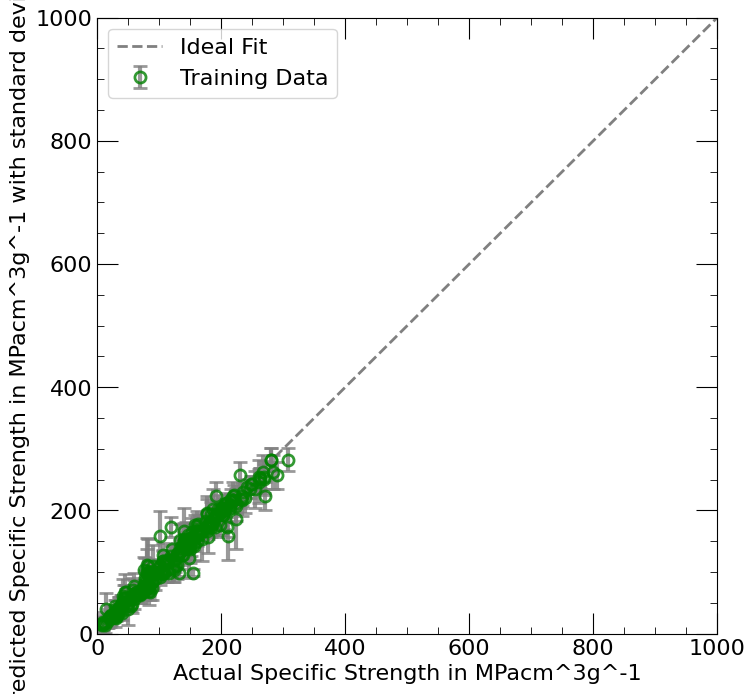

In [25]:
plt.figure(figsize=(8,8))

plt.errorbar(Y_train,mean_train,yerr=std_train,mfc='None',mec='green',mew=2,ecolor = 'grey',alpha=0.8, elinewidth= 3,ls = 'none',marker='o',markersize=8,solid_capstyle='projecting', capsize=5,label='Training Data')
plt.xlabel('Actual Specific Strength in MPacm^3g^-1',fontsize=16)
plt.ylabel('Predicted Specific Strength in MPacm^3g^-1 with standard deviation',fontsize=16)
plt.axline((0, 0), (1000, 1000), linewidth=2, color='grey',linestyle='dashed',label='Ideal Fit')
plt.legend(fontsize=16)

plt.minorticks_on()
plt.tick_params(labelsize=16)
plt.tick_params(direction='in',which='major', length=15, bottom=True, top=True, left=True, right=True,colors='k')
plt.tick_params(direction='in',which='minor', length=5, bottom=True, top=True, left=True, right=True,colors='k')


plt.xlim(0,1000)
plt.ylim(0,1000)
print('r2 score test data:',r2_score(Y_test,mean))
print('r2 score train data:',r2_score(Y_train,mean_train))

# mean_squared_error(y_test,mean,squared=False)
# mean_absolute_error(y_test,mean)

### Reading .csv file of composition (candidate search space)  and converting weight percent to atom percent

In [27]:
df_test_composition = pd.read_csv('/content/compositions_test_candidates_4_allcombinations.csv')
df_test_total = df_test_composition[['formula','Temperature','target']]

df_test_total.head()



,formula,Temperature,target
0,Nb97Al1Co1Cr1,24,0
1,Nb96Al1Co1Cr2,24,0
2,Nb95Al1Co1Cr3,24,0
3,Nb94Al1Co1Cr4,24,0
4,Nb93Al1Co1Cr5,24,0


In [28]:
print(len(df_test_total))
df_test_final = df_test_total
df_test_final.tail()

100000


,formula,Temperature,target
99995,Nb91Al4Co4V1,24,0
99996,Nb90Al4Co4V2,24,0
99997,Nb89Al4Co4V3,24,0
99998,Nb88Al4Co4V4,24,0
99999,Nb87Al4Co4V5,24,0


In [29]:
df_test_final = df_test_final.head(1000)
print(len(df_test_final))

1000


### Generate Features for the search space using CBFV

In [30]:
X_test_comp, y_test_comp, formulae_test_comp, skipped_train = composition.generate_features(df_test_final,elem_prop='magpie',drop_duplicates=False,extend_features=True)

Processing Input Data: 100%|██████████| 1000/1000 [00:00<00:00, 27740.66it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 1000/1000 [00:00<00:00, 9344.56it/s]

	Creating Pandas Objects...


In [31]:
print('maximum value of the Specific Strength in the experimental data:',y1.max())

maximum value of the Specific Strength in the experimental data: 309.7


In [32]:
scaler = StandardScaler()
X_Scaled = scaler.fit_transform(x1)
X_test_comp_scaled  = scaler.transform(X_test_comp) # transform test data

In [33]:
# Estimating mean and standard deviation for all the available experimental data
mean_train_all , std_train_all  = bootstrap_estimator(best_model, X_Scaled , y1, X_Scaled, n_iter=100)


In [34]:
ei,predicted_property,std = Expected_Improvement(X_test_comp_scaled, X_Scaled ,y1,best_model,xi=0.01)


In [35]:
df_predict = pd.DataFrame({"ei":ei, "std":std})
df_predict_final = df_test_final.join(df_predict)
df_predict_final["target"] = predicted_property
df_predict_final_sorted = df_predict_final.sort_values('ei',ascending=False)
#df_predict_final_sorted.to_csv('/content/ei_SS_sorted_new.csv')
df_predict_final_sorted


,formula,Temperature,target,ei,std
15,Nb82Al1Co1Cr16,24,186.316301,3.395431e-05,28.134968
16,Nb81Al1Co1Cr17,24,187.835697,3.238851e-05,27.744643
927,Nb82Al2Co13Cr3,24,193.650381,1.841661e-05,25.822674
775,Nb90Al2Co7Cr1,24,178.273974,1.546697e-05,28.870037
39,Nb82Al1Co2Cr15,24,187.875311,1.407101e-05,26.739788
...,...,...,...,...,...
505,Nb72Al1Co21Cr6,24,195.586514,2.144956e-11,16.973025
796,Nb69Al2Co7Cr22,24,192.878143,2.134380e-11,17.365577
845,Nb68Al2Co9Cr21,24,191.320413,1.820121e-11,17.534385
798,Nb67Al2Co7Cr24,24,192.451670,1.481008e-11,17.296816


In [37]:
# First filter to keep only rows with temperature = 25, then sort by target
od_sorted = data[data['Temperature'] == 25].sort_values('target', ascending=False)

In [38]:
od_max_5 = od_sorted.head()
od_max_5

,formula,Temperature,target
25,Al0.5Mo0.5NbTa0.5TiZr,25.0,309.7
64,AlMo0.5NbTa0.5TiZr,25.0,307.4
40,AlCr0.5NbTiV,25.0,290.1
66,AlMo0.5NbTa0.5TiZr,25.0,279.8
73,AlMo0.5NbTa0.5TiZr,25.0,279.8


In [39]:
od_min_5 = od_sorted.tail()
od_min_5

,formula,Temperature,target
307,MoNbTaW,25.0,77.5
263,HfTa0.5TiZr,25.0,74.7
306,MoNbTaW,25.0,72.9
213,HfNb0.18Ta0.18Ti1.27Zr,25.0,63.8
262,HfTa0.4TiZr,25.0,43.5


In [40]:
ei_top_5 = df_predict_final_sorted.head()
ei_top_5

,formula,Temperature,target,ei,std
15,Nb82Al1Co1Cr16,24,186.316301,0.000034,28.134968
16,Nb81Al1Co1Cr17,24,187.835697,0.000032,27.744643
927,Nb82Al2Co13Cr3,24,193.650381,0.000018,25.822674
775,Nb90Al2Co7Cr1,24,178.273974,0.000015,28.870037
39,Nb82Al1Co2Cr15,24,187.875311,0.000014,26.739788


In [41]:
ei_top_5 = ei_top_5[["formula","Temperature","target"]]
ei_top_5

,formula,Temperature,target
15,Nb82Al1Co1Cr16,24,186.316301
16,Nb81Al1Co1Cr17,24,187.835697
927,Nb82Al2Co13Cr3,24,193.650381
775,Nb90Al2Co7Cr1,24,178.273974
39,Nb82Al1Co2Cr15,24,187.875311


In [42]:
x_od_max5, y_od_max5, feature_max_5, skipped_max5 = composition.generate_features(od_max_5, elem_prop="magpie", drop_duplicates=False, extend_features=True)

Processing Input Data: 100%|██████████| 5/5 [00:00<00:00, 10634.65it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 5/5 [00:00<00:00, 5546.55it/s]

	Creating Pandas Objects...


In [43]:
x_od_min5, y_od_min5, feature_min_5, skipped_min5 = composition.generate_features(od_min_5, elem_prop="magpie", drop_duplicates=False, extend_features=True)

Processing Input Data: 100%|██████████| 5/5 [00:00<00:00, 9137.92it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 5/5 [00:00<00:00, 2818.37it/s]

	Creating Pandas Objects...


In [44]:
x_ei_top5, y_ei_top5, feature_top_5, skipped_top5 = composition.generate_features(ei_top_5, elem_prop="magpie", drop_duplicates=False, extend_features=True)

Processing Input Data: 100%|██████████| 5/5 [00:00<00:00, 11976.88it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 5/5 [00:00<00:00, 6078.70it/s]

	Creating Pandas Objects...


In [45]:
# Step 1: Combine the standardized feature sets
X_combined = np.vstack([x_od_max5, x_od_min5, x_ei_top5])

In [46]:
#standardize the dataset
scaler = StandardScaler()
X_comb_std = scaler.fit_transform(X_combined)

In [47]:
X_comb_std.shape

(15, 133)

In [48]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [49]:
pca = PCA(n_components=2)
X_comb_std = pca.fit_transform(X_comb_std)

In [50]:
tsne = TSNE(n_components=2, perplexity=3, random_state=42, n_iter=1000)
X_comb_tsne = tsne.fit_transform(X_comb_std)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


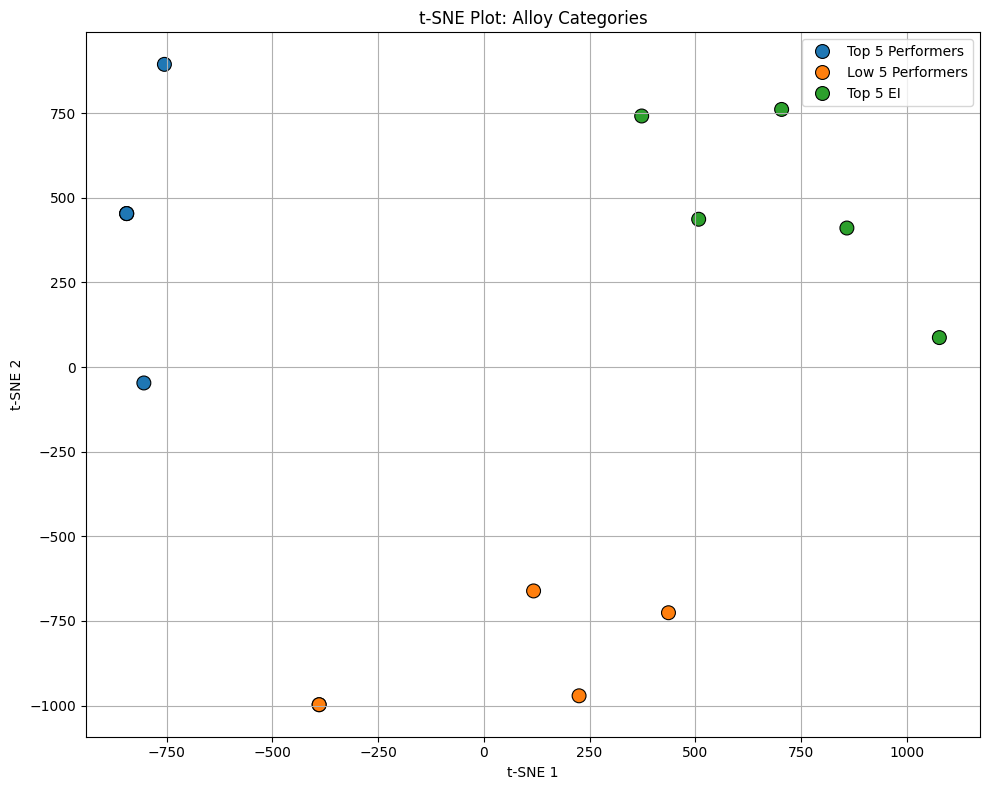

In [51]:
labels = (['Top 5 Performers'] * len(x_od_max5) +
          ['Low 5 Performers'] * len(x_od_min5) +
          ['Top 5 EI'] * len(x_ei_top5))



# Create DataFrame
dfp1 = pd.DataFrame(X_comb_tsne, columns=["TSNE1", "TSNE2"])
dfp1["Category"] = labels


# Plotting
plt.figure(figsize=(10, 8))
palette = {"Top 5 Performers": "#1f77b4", "Low 5 Performers": "#ff7f0e", "Top 5 EI": "#2ca02c"}

sns.scatterplot(
    data=dfp1,
    x="TSNE1",
    y="TSNE2",
    hue="Category",
    palette=palette,
    s=100,
    edgecolor='black',
    marker='o'  # circle marker
)



# Final plot settings
plt.title("t-SNE Plot: Alloy Categories")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title='', loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


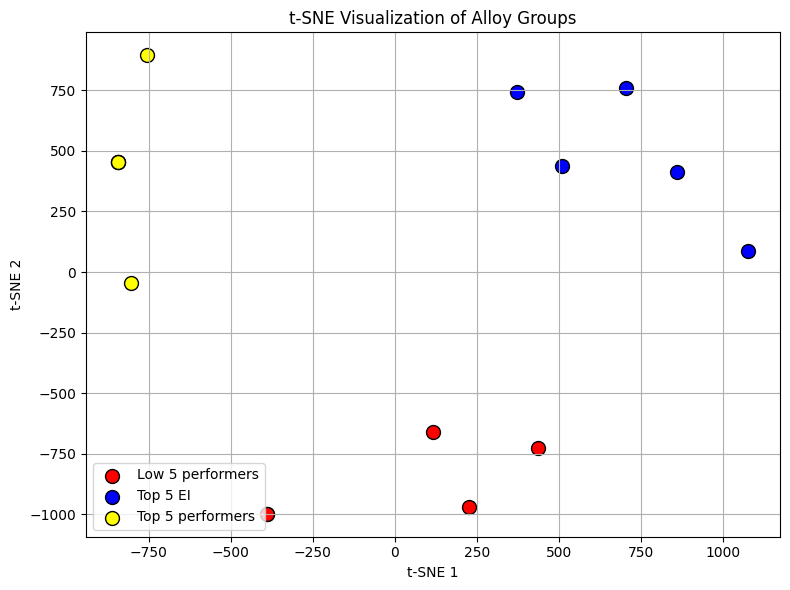

In [52]:


# Step 2: Create group labels
labels = (
    ['Top 5 performers'] * len(x_od_max5) +
    ['Low 5 performers'] * len(x_od_min5) +
    ['Top 5 EI'] * len(x_ei_top5)
)

# Step 3: Run t-SNE once on combined features
tsne = TSNE(n_components=2, perplexity=3, random_state=42, n_iter=1000)
X_tsne = tsne.fit_transform(X_comb_std)
colors = {'Top 5 performers': 'yellow', 'Low 5 performers': 'red', 'Top 5 EI': 'blue'}

plt.figure(figsize=(8, 6))
for label in np.unique(labels):
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=label, color=colors[label], s=100, edgecolors='k')


plt.title("t-SNE Visualization of Alloy Groups")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [53]:
len(x_ei_top5)

5

In [57]:
# Assuming 'df' is your original DataFrame with 'target' column and 'composition' column

# Step 1: Get bottom 5 indices for minimum target values
bottom_5_min_indices = data[data['Temperature'] == 25].sort_values('target', ascending=True).head(5).index

# Step 2: Extract the corresponding composition rows
bottom_5_min_compositions_df = data.loc[bottom_5_min_indices].reset_index(drop=True)

# Step 3: Run feature generation
X_min_c, y_min, formulae_min, skipped_min = composition.generate_features(
    bottom_5_min_compositions_df,
    elem_prop='magpie',  # Assuming you want to use 'oliynyk' features
    drop_duplicates=False,
    extend_features=False,

)

# Display the bottom 5 compositions
print(bottom_5_min_compositions_df)

Processing Input Data: 100%|██████████| 5/5 [00:00<00:00, 11976.88it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 5/5 [00:00<00:00, 4449.72it/s]

	Creating Pandas Objects...
                  formula  Temperature  target
0             HfTa0.4TiZr         25.0    43.5
1  HfNb0.18Ta0.18Ti1.27Zr         25.0    63.8
2                 MoNbTaW         25.0    72.9
3             HfTa0.5TiZr         25.0    74.7
4                 MoNbTaW         25.0    77.5


In [ ]:
data[data['Temperature'] == 25].sort_values('target', ascending=False)

In [58]:
# Step 1: Get top 5 indices from UCB=1 results
# Instead of using indices, use the 'formula' column directly
top_5_ei_1 = df_predict_final.sort_values(by='ei', ascending=False).head(5)['formula'].tolist()

# Step 2: Extract only the relevant composition rows from the full dataset
# Get the 'formula' values from ei_top_5
# top_5_formulas = ei_top_5['formula'].tolist()  # No longer needed

# Filter the original DataFrame 'df' based on these formulas
top_5_compositions_df = df_predict_final[df_predict_final['formula'].isin(top_5_ei_1)].reset_index(drop=True)

# Step 3: Run feature generation using only the composition column
X_ei_c, y_ei, formulae_ucb, skipped_ucb = composition.generate_features(
    top_5_compositions_df,
    elem_prop='magpie',
    drop_duplicates=False,
    extend_features=True,
)


Processing Input Data: 100%|██████████| 5/5 [00:00<00:00, 11592.88it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 5/5 [00:00<00:00, 6066.39it/s]

	Creating Pandas Objects...


In [60]:
# Step 1: Get top 5 indices from UCB=1.5 results
top_5_max = data[data['Temperature'] == 25].sort_values('target', ascending=False).head(5).index

# Step 2: Extract only the relevant composition rows from the full dataset
top_5_compositions_df = data.loc[top_5_max].reset_index(drop=True)

# Step 3: Run feature generation using only the composition column
X_max_c, y_max, formulae_max, skipped_max = composition.generate_features(
    top_5_compositions_df,
    elem_prop='magpie',
    drop_duplicates=False,
    extend_features=True,

)
top_5_compositions_df

Processing Input Data: 100%|██████████| 5/5 [00:00<00:00, 6999.84it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 5/5 [00:00<00:00, 5351.24it/s]

	Creating Pandas Objects...


,formula,Temperature,target
0,Al0.5Mo0.5NbTa0.5TiZr,25.0,309.7
1,AlMo0.5NbTa0.5TiZr,25.0,307.4
2,AlCr0.5NbTiV,25.0,290.1
3,AlMo0.5NbTa0.5TiZr,25.0,279.8
4,AlMo0.5NbTa0.5TiZr,25.0,279.8


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


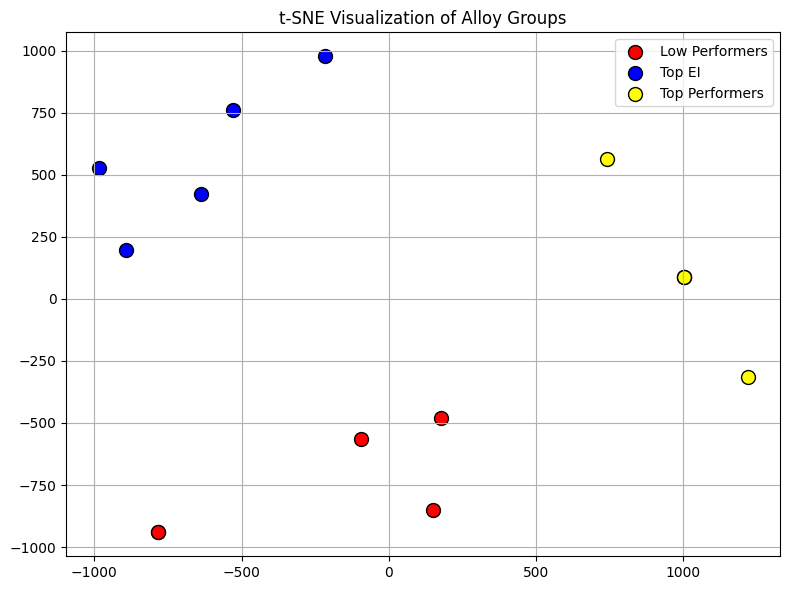

In [61]:
from sklearn.manifold import TSNE
scaler = StandardScaler()
common_cols = list(set(X_max_c.columns) & set(X_min_c.columns) & set(X_ei_c.columns))

# 2. Select only the common columns from each DataFrame:
X_max_c_common = X_max_c[common_cols]
X_min_c_common = X_min_c[common_cols]
X_ei_c_common = X_ei_c[common_cols]

# 3. Now you can stack them:
X_combined = np.vstack([X_max_c_common, X_min_c_common, X_ei_c_common])

# 4. Continue with scaling:
scaler = StandardScaler()
X_scaled_all = scaler.fit_transform(X_combined)


# Then split them back:
X_scaled_max = X_scaled_all[:len(X_max_c_common)]
X_scaled_min = X_scaled_all[len(X_max_c_common):len(X_max_c_common)+len(X_min_c_common)]
X_scaled_ei_c = X_scaled_all[-len(X_ei_c_common):]

# Step 1: Combine the standardized feature sets
X_combined = np.vstack([X_scaled_max, X_scaled_min, X_scaled_ei_c])

# Step 2: Create group labels
labels = (
    ['Top Performers'] * len(X_scaled_max) +
    ['Low Performers'] * len(X_scaled_min) +
    ['Top EI'] * len(X_scaled_ei_c)
)

# Step 3: Run t-SNE once on combined features
tsne = TSNE(n_components=2, perplexity=3, random_state=42, n_iter=1000)
X_tsne = tsne.fit_transform(X_combined)

# Fix: Correct the key in the 'colors' dictionary to match the labels
colors = {'Top Performers': 'yellow', 'Low Performers': 'red', 'Top EI': 'blue'}

plt.figure(figsize=(8, 6))
for label in np.unique(labels):
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=label, color=colors[label], s=100, edgecolors='k')

plt.title("t-SNE Visualization of Alloy Groups")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()